In [1]:
%load_ext autoreload
%autoreload 2

# init and load image - visium tutorial

In [13]:
import os
import numpy as np 
from bokeh.plotting import show, output_notebook
import pandas as pd
import socket
os.chdir(path_to_tissue_tag)
import tissue_tag as tt
import matplotlib.pyplot as plt
import scanpy as sc
os.environ['BOKEH_ALLOW_WS_ORIGIN']='*'
output_notebook()
host = '5011'

Loading BokehJS ...

# Step 1 - Load image and define annotation names and colors 

Text(0.5, 1.0, 'ppm - 0.1')

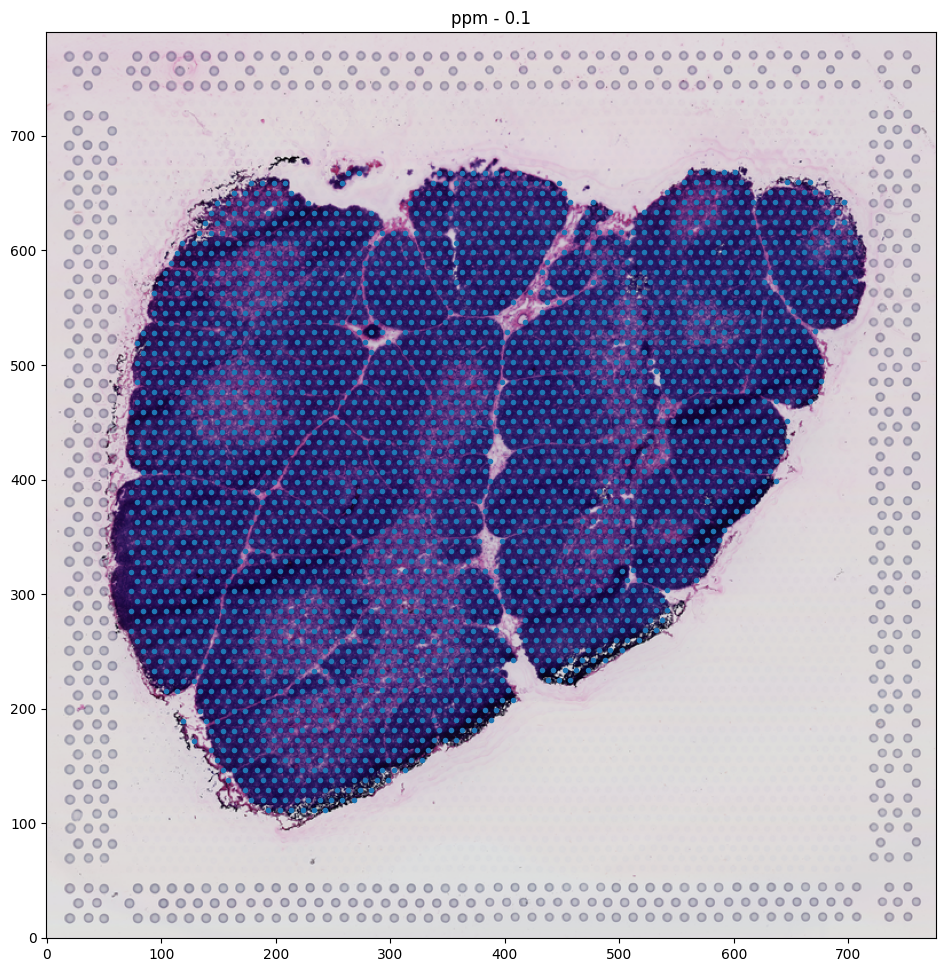

In [16]:
plt.figure(figsize=[12,12])
vis_path = path_to_tissue_tag+'data/tissue_tag_minimal_example_visium/'
im,ppm,df = tt.read_visium(spaceranger_dir_path=vis_path,use_resolution='hires',res_in_ppm=0.1)
coordinates = np.vstack((df[5],df[4]))
plt.imshow(im,origin='lower')
plt.plot(coordinates[0,:],coordinates[1,:],'.')
plt.title( 'ppm - '+str(ppm))

# Step 2 - (optional) Predict regions from image

## scribble iniital annotations

## Step 2 - Manually draw annotations or Correct forest annotations (Step 2)

In [5]:
# define annotations Lv0 
annodict = {
    'lobes':'green'
}
# at this stage, if you are adding annotations make sure they come after the current ones otherwise it will mess up everything
result = np.zeros((im.shape[0],im.shape[1]), dtype=np.uint8) # blank annotation image

result_rgb = tt.rgb_from_labels(result,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5,show=False)
tabs,render_dict = tt.poly_annotator(im,out_img,anno_dict=annodict)

# plotting
def app(doc):
    global tabs
    doc.add_root(tabs)
show(app,notebook_url=f'{socket.gethostname()}:'+host)
print('this takes up to a 20 sec on farm')

this takes up to a few minutes on farm


## plot annotations 

lobes
{'unassigned': 'yellow', 'lobes_0': 'brown', 'lobes_1': 'red', 'lobes_2': 'magenta', 'lobes_3': 'red', 'lobes_4': 'red', 'lobes_5': 'brown'}


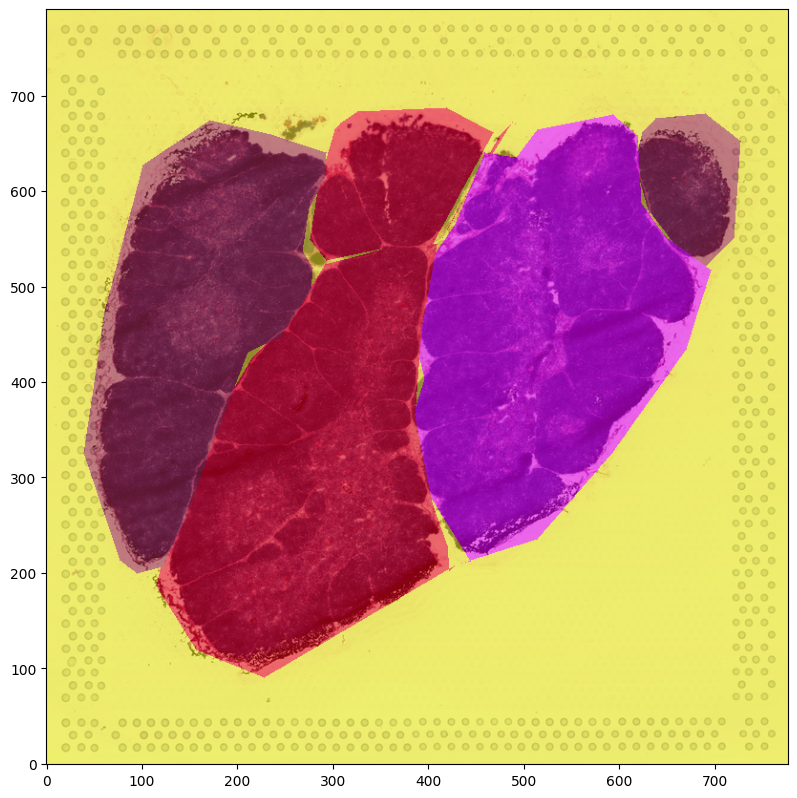

In [6]:
result,object_dict  = tt.object_annotator(im,result,anno_dict=annodict,render_dict=render_dict,alpha=0.5)
print(object_dict)
# plot result 
result_rgb = tt.rgb_from_labels(result,colors=list(object_dict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)
plt.show()

## save annotation 

In [7]:
isExist = os.path.exists(vis_path+'tissue_annotations')
if not(isExist):
    os.mkdir(vis_path+'/tissue_annotations/')
    
tt.save_annotation(
    folder=vis_path+'/tissue_annotations/',
    label_image=result,
    file_name='annotations_'+list(annodict.keys())[0],
    anno_names=list(object_dict.keys()),
    anno_colors=list(object_dict.values()),
    ppm = ppm,
)

# load tissue annotations from tissue tag

loaded annotation image - annotations_lobes size - (791, 777)
loaded annotations
{1: 'unassigned', 2: 'lobes_0', 3: 'lobes_1', 4: 'lobes_2', 5: 'lobes_3', 6: 'lobes_4', 7: 'lobes_5'}
loaded ppm
{'ppm': 0.1}
loaded color annotations
{'unassigned': 'yellow', 'lobes_0': 'brown', 'lobes_1': 'red', 'lobes_2': 'magenta', 'lobes_3': 'red', 'lobes_4': 'red', 'lobes_5': 'brown'}
[1 2 3 4 5 6 7]


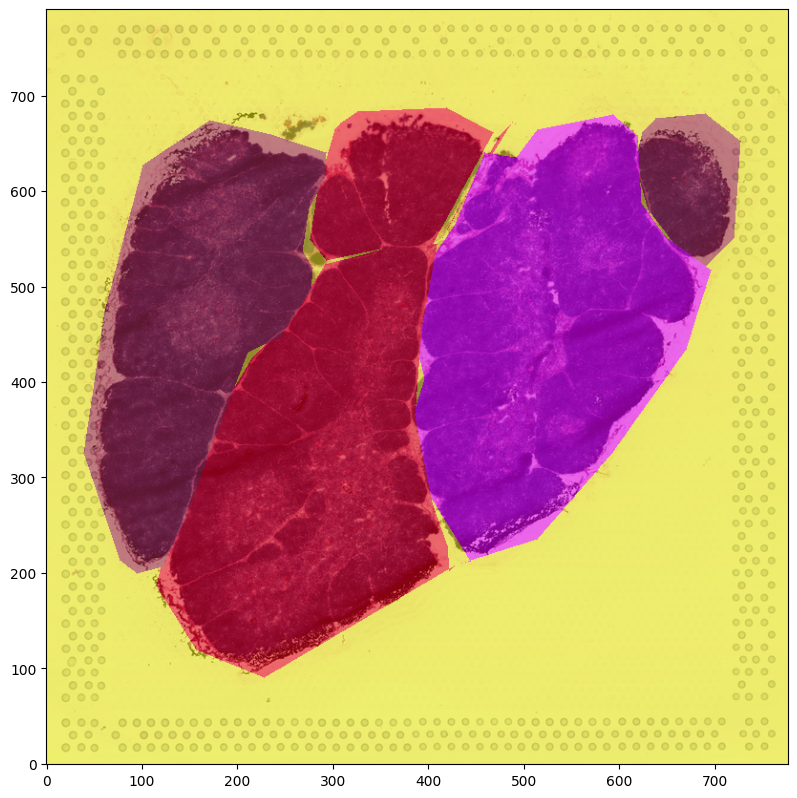

In [17]:
annotations,annotations_labels,ppm,annodict = tt.load_annotation(vis_path+'/tissue_annotations/','annotations_lobes',load_colors=True)
im,ppm,positions = tt.read_visium(spaceranger_dir_path=vis_path+'/',use_resolution='hires',res_in_ppm=ppm)
result_rgb = tt.rgb_from_labels(annotations,colors=list(annodict.values()))
out_img = tt.overlay_labels(im,result_rgb,alpha=0.5)
print(np.unique(annotations))

## migrate annotations to hi res grid sapce 


In [18]:
%%time
# it's critical not to split cell part and recalculate the df everytime you cahnge the dist2cluster resolution - I have an overflow bug somewhere that I need to fix
spot_diameter = 30 # don't go crazy here avoid under 15um spots 
df = tt.grid_anno(
    im,
    [annotations],
    ['annotations'],
    [annotations_labels],
    spot_diameter=spot_diameter,
    ppm_in=ppm,
    ppm_out=ppm,
)
df

generating grid with spot size - 30, with resolution of - 0.1 ppm
annotations


68640it [00:08, 7912.92it/s]

CPU times: user 8.7 s, sys: 44 ms, total: 8.74 s
Wall time: 8.72 s


x           y annotations  annotations_number
index                                                   
0        3.0    3.000000  unassigned                   1
1        3.0    5.984791  unassigned                   1
2        3.0    8.969582  unassigned                   1
3        3.0   11.954372  unassigned                   1
4        3.0   14.939163  unassigned                   1
...      ...         ...         ...                 ...
68635  774.0  777.560852  unassigned                   1
68636  774.0  780.545654  unassigned                   1
68637  774.0  783.530396  unassigned                   1
68638  774.0  786.515198  unassigned                   1
68639  774.0  789.500000  unassigned                   1

[68640 rows x 4 columns]

In [19]:
# remove background spots
# df = df.iloc[np.where(df['annotations']!='unassigned')[0],:]

## move annotation and distances to visium spots 

In [20]:
# calculate distance matrix between hires and visium spots
positions = tt.anno_to_visium_spots(
    df_spots=positions,
    df_grid=df,
    plot=False,
)
positions

Make sure the coordinate systems are aligned, e.g., axes are not flipped.
Migrating - annotations to segmentations.
Migrating - annotations_number to segmentations.


1     2      3           4           5 annotations  \
0                                                                          
GTATTCTTACCGTGCT-1  1.0   7.0   21.0  120.122387  178.557632     lobes_3   
GCGGTAACCCAAATGA-1  1.0   7.0   23.0  120.143196  188.515124     lobes_3   
CTACGTGTTGCCACCA-1  1.0   6.0   24.0  111.467050  193.499541     lobes_3   
CTAGATAAACTCCTCG-1  1.0   7.0   25.0  120.164004  198.472617     lobes_3   
TCCATTAGTTGGATAG-1  1.0   6.0   26.0  111.487859  203.457034     lobes_3   
...                 ...   ...    ...         ...         ...         ...   
CTTGATGACCATCCAG-1  1.0  70.0   98.0  668.176154  561.563845     lobes_2   
CTTGCCCACCCACGCA-1  1.0  70.0  100.0  668.196963  571.521337     lobes_2   
GGACAACCATGAAGCC-1  1.0  70.0  102.0  668.217771  581.478830     lobes_2   
AGGTGCACGTCCACAT-1  1.0  70.0  104.0  668.238580  591.436322     lobes_2   
ACCAAGTCATCGGCAG-1  1.0  70.0  106.0  668.259389  601.393815     lobes_2   

                    annotations_number  
0                                       
GTATTCTTACCGTGCT-1                   5  
GCGGTAACCCAAATGA-1                   5  
CTACGTGTTGCCACCA-1                   5  
CTAGATAAACTCCTCG-1                   5  
TCCATTAGTTGGATAG-1                   5  
...                                ...  
CTTGATGACCATCCAG-1                   4  
CTTGCCCACCCACGCA-1                   4  
GGACAACCATGAAGCC-1                   4  
AGGTGCACGTCCACAT-1                   4  
ACCAAGTCATCGGCAG-1                   4  

[2958 rows x 7 columns]

/nfs/team205/ny1/miniconda/miniconda3/envs/imagespot/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


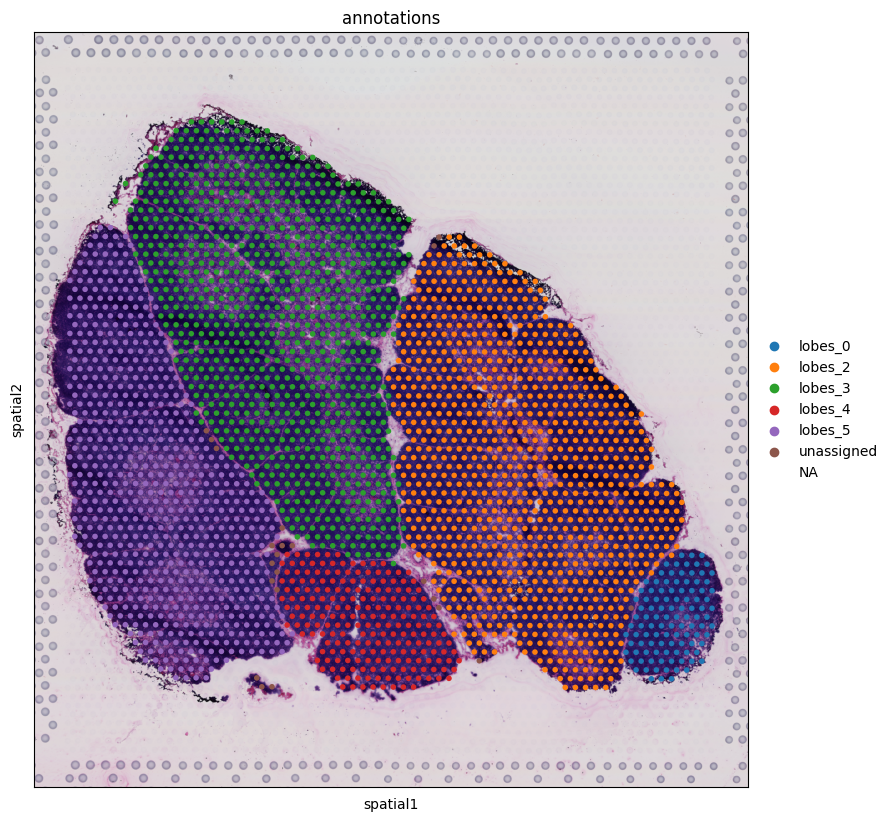

In [22]:
import scanpy as sc
adata_vis = sc.read_visium(vis_path,count_file='raw_feature_bc_matrix.h5')
adata_vis.obs = pd.concat([adata_vis.obs,positions.iloc[:,5:]],axis=1)
sc.pl.spatial(adata_vis,color=['annotations'],cmap='tab10',ncols=2)